In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 30 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node+1, deg, e, seed=42)

In [3]:
from model import vrpModel
# demands
demands = np.random.rand(num_node) * 10
# set solver
optmodel = vrpModel(num_node+1, demands=demands, capacity=30, num_vehicle=8)
# set time limit
optmodel._model.Params.timelimit = 60
# solve
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {:.4f}".format(obj))
route = optmodel.getTour(sol)
for tour in route:
    print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 64.5109
0 -> 2 -> 14 -> 26 -> 20 -> 1 -> 16 -> 30 -> 0
0 -> 3 -> 28 -> 21 -> 24 -> 11 -> 15 -> 5 -> 17 -> 0
0 -> 7 -> 18 -> 9 -> 6 -> 10 -> 19 -> 23 -> 0
0 -> 8 -> 12 -> 22 -> 29 -> 0
0 -> 13 -> 25 -> 4 -> 27 -> 0


### Load  Datasets 

In [4]:
# save tensors
x_train = torch.load("./data/feats_train_vrp30.pt")
c_train = torch.load("./data/costs_train_vrp30.pt")
w_train = torch.load("./data/sols_train_vrp30.pt")
ctr_train = torch.load("./data/ctrs_train_vrp30.pt")

# save tensors
x_test = torch.load("./data/feats_test_vrp30.pt")[:10]
c_test = torch.load("./data/costs_test_vrp30.pt")[:10]
w_test = torch.load("./data//sols_test_vrp30.pt")[:10]
ctr_test = torch.load("./data//ctrs_test_vrp30.pt")[:10]

In [5]:
# ceate dataset with a dummy solver
import gurobipy as gp
from gurobipy import GRB
from pyepo.model.grb.grbmodel import optGrbModel
class dummyModel(optGrbModel):
    def _getModel(self):
        # ceate a model
        m = gp.Model()
        # varibles
        x = m.addVars(c_train.shape[1], name="x", vtype=GRB.BINARY)
        # model sense
        m.modelSense = GRB.MAXIMIZE
        return m, x
    
# set solver
dummy_model = dummyModel()
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(dummy_model, x_train, costs=c_train)
dataset_test = pyepo.data.dataset.optDataset(dummy_model, x_test, costs=c_test)
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(dummy_model, x_train, costs=c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 933/933 [00:20<00:00, 45.59it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 52.98it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 933/933 [00:32<00:00, 28.28it/s]


In [6]:
# add VRP data
dataset_train_cost.feats = x_train
dataset_train_cost.costs = c_train
dataset_train_cost.sols = w_train
dataset_train_cost.objs = torch.sum(c_train*w_train, dim=1)
dataset_train.feats = x_train
dataset_train.costs = c_train
dataset_train.sols = w_train
dataset_train.ctrs = ctr_train
dataset_test.feats = x_test
dataset_test.costs = c_test
dataset_test.sols = w_test
dataset_test.objs = torch.sum(c_test*w_test, dim=1)

In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node+1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
import metric

def pipeline(reg, forward_func, loss_func, lr, num_epochs, loader_train, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log = []
    grad_log = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    print()
    print("Plot:")
    plot(loss_log, grad_log)
    print()
    print("Evaluation:")
    tick = time.time()
    test_regret, _ = metric.regret(reg, optmodel, loader_test)
    tock = time.time()
    elapsed = tock - tick
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Test Elapsed Time: {:.2f} Sec".format(elapsed))


def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func, grad_log):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, c)
    return loss

Epoch   19, Loss:  12.3111: 100%|██████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.30s/it]


Training Elapsed Time: 5.87 Sec

Plot:


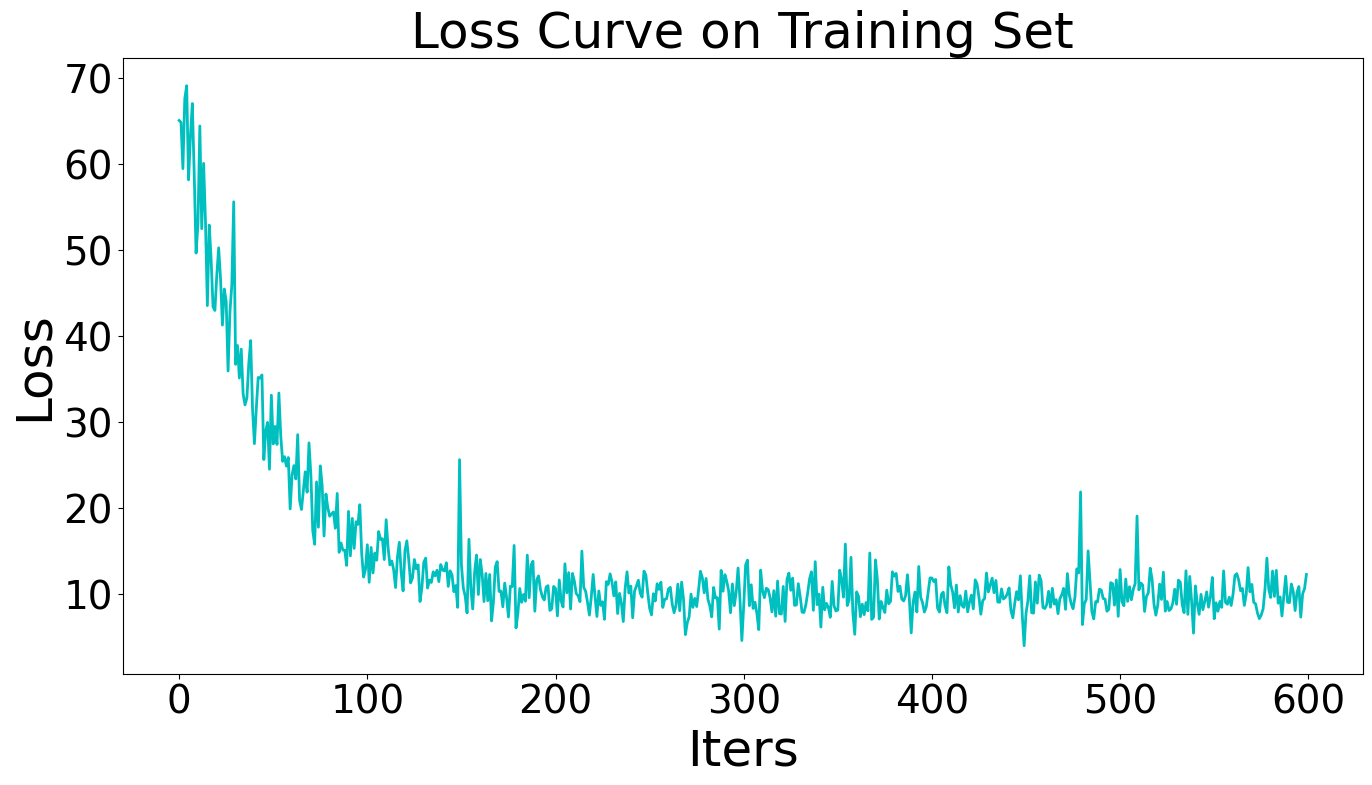

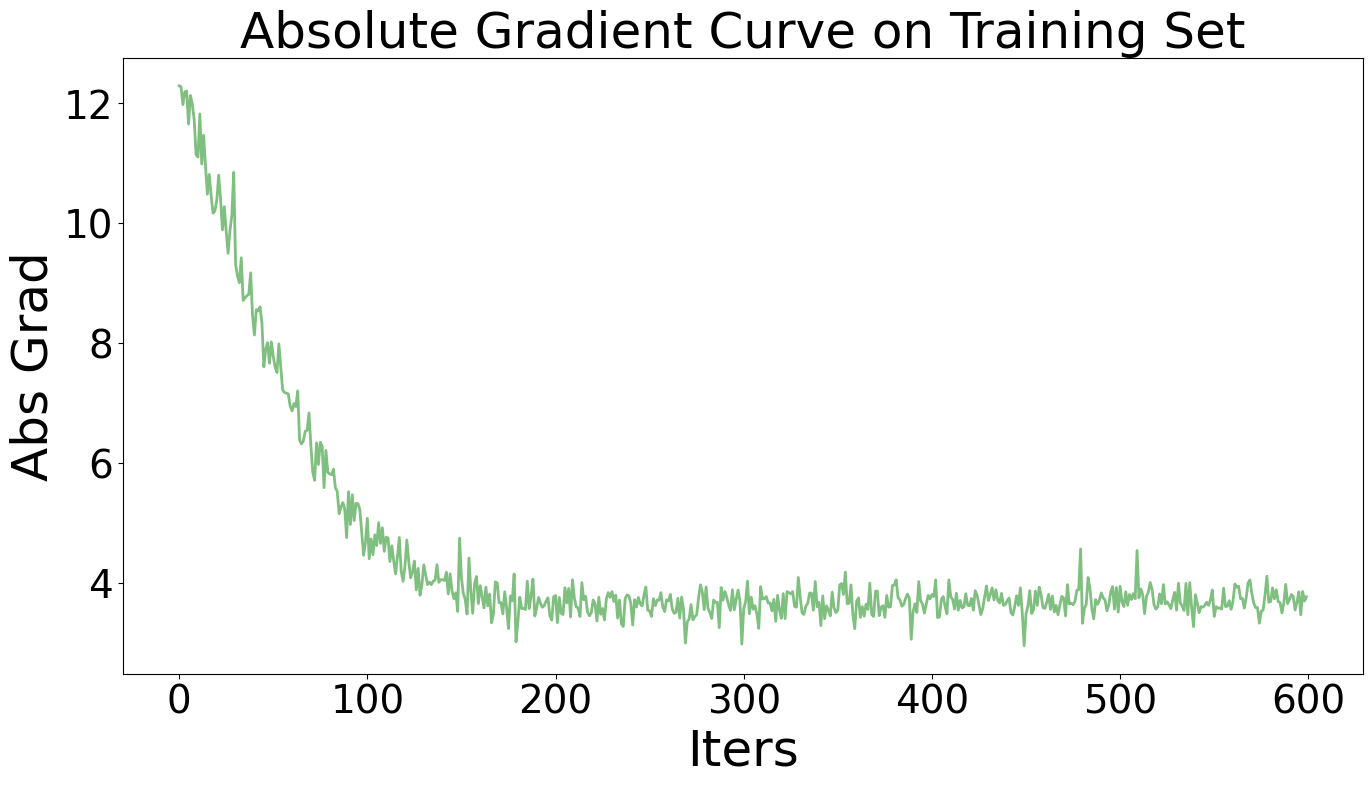


Evaluation:


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:56<00:00, 17.64s/it]

Test Regret: 20.0364%
Test Elapsed Time: 176.43 Sec


In [14]:
lr = 5e-2
pipeline(reg, forward2S, mse, lr, num_epochs, loader_train_cost, loader_test)

### Exact Method with Clarabe

In [23]:
# init model
reg = LinearRegression()

In [22]:
from func import exactConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


Epoch   19, Loss:  -0.9977: 100%|██████████████████████████████████████████████████████| 20/20 [05:06<00:00, 15.34s/it]


Training Elapsed Time: 286.60 Sec

Plot:


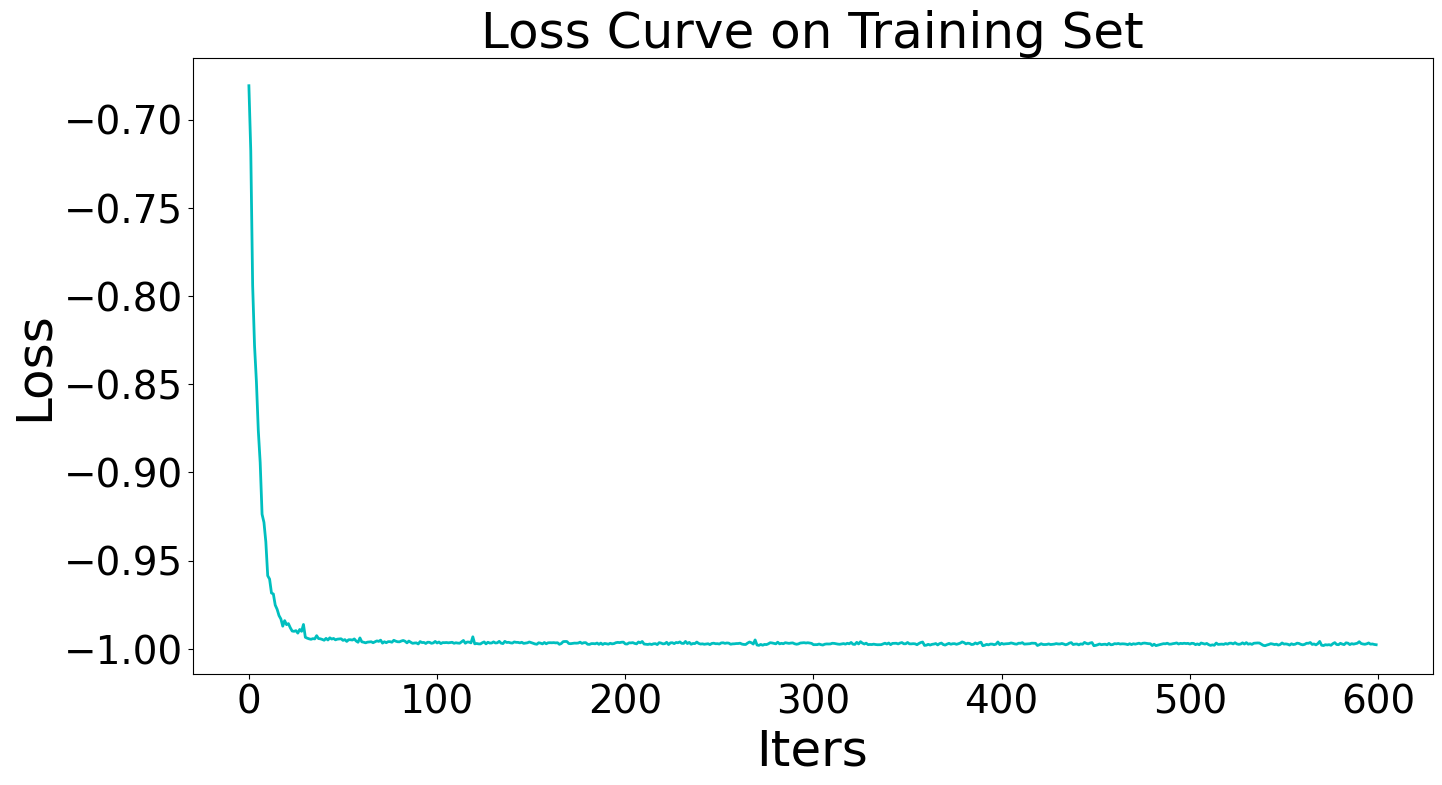

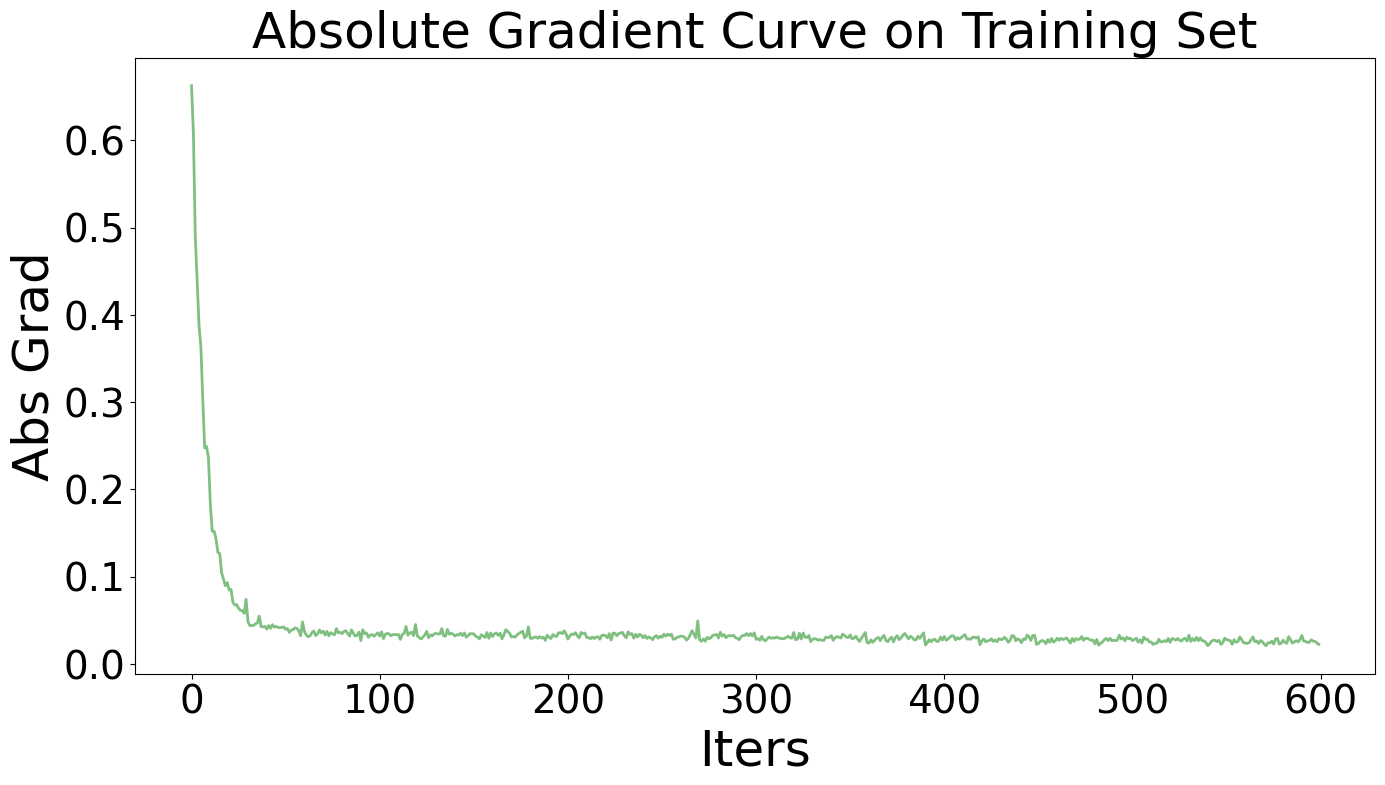


Evaluation:


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:46<00:00, 10.66s/it]

Test Regret: 9.1251%
Test Elapsed Time: 106.57 Sec


In [24]:
lr = 5e-2
pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, loader_train, loader_test)

### Inner Method with Clarabel

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


Epoch   19, Loss:  -0.9977: 100%|██████████████████████████████████████████████████████| 20/20 [05:37<00:00, 16.89s/it]


Training Elapsed Time: 317.54 Sec

Plot:


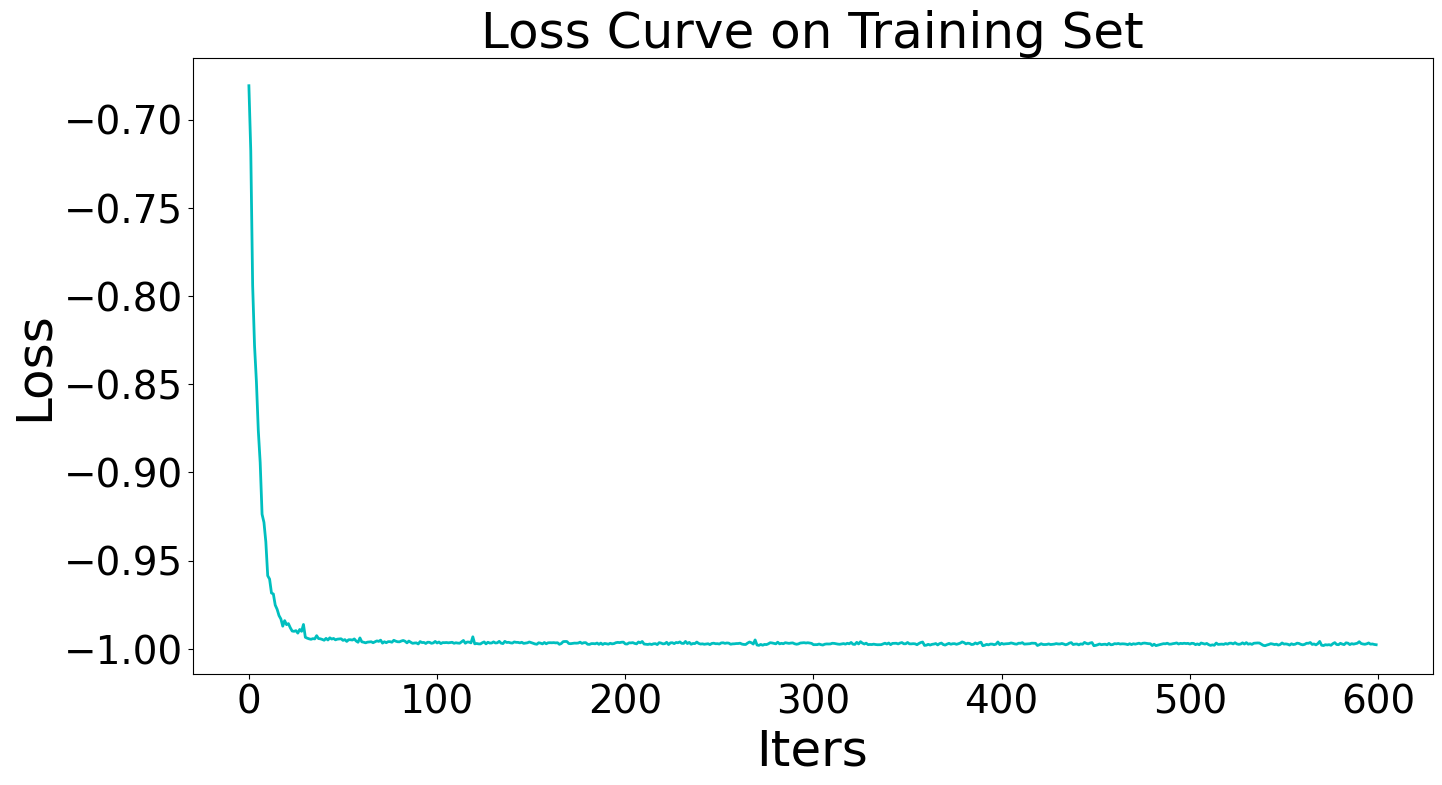

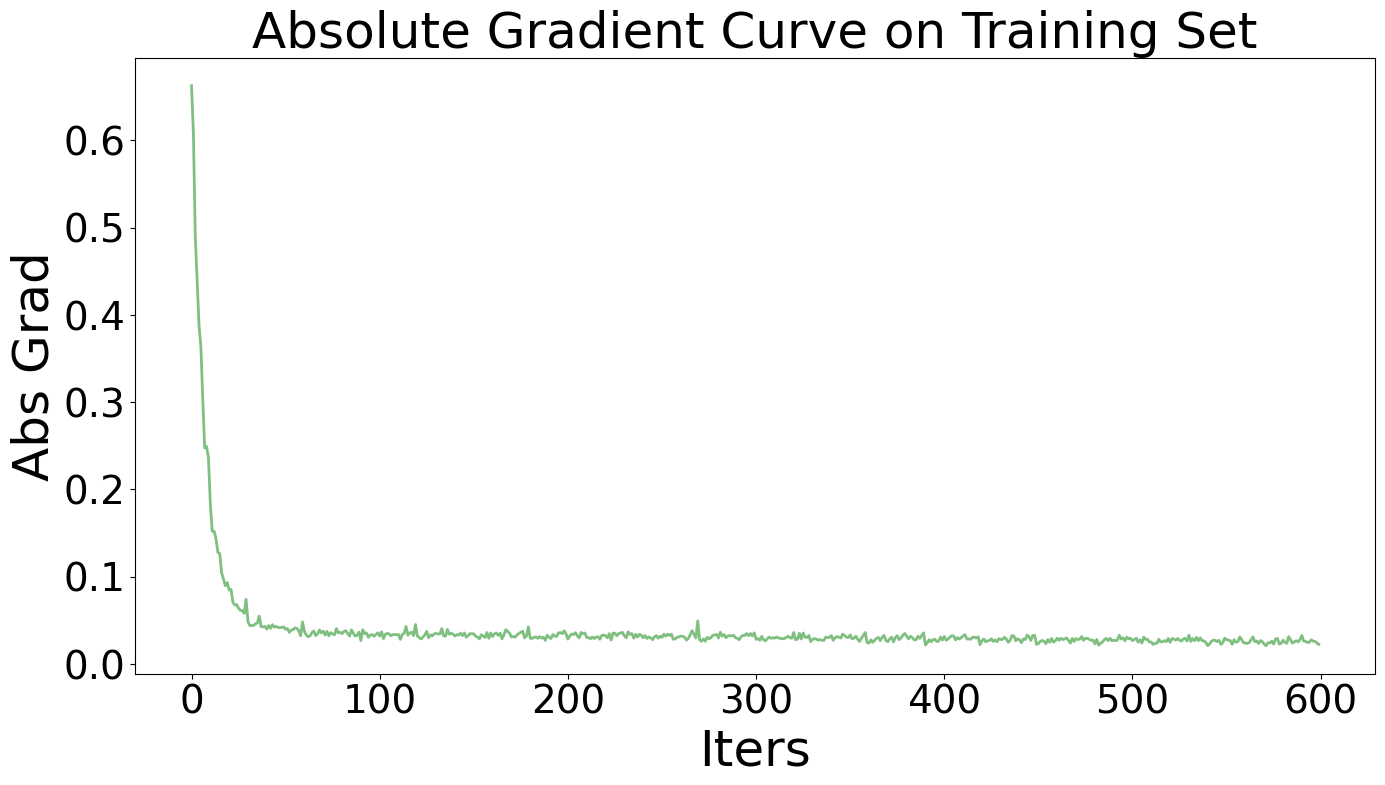


Evaluation:


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:43<00:00, 10.39s/it]

Test Regret: 9.1251%
Test Elapsed Time: 103.87 Sec


In [17]:
lr = 5e-2
pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, loader_train, loader_test)

### Inner & Average Method

In [19]:
# init model
reg = LinearRegression()

In [20]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", solve_ratio=0.3, processes=8)

Num of cores: 8


Epoch   19, Loss:  -0.9967: 100%|██████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.40s/it]


Training Elapsed Time: 127.80 Sec

Plot:


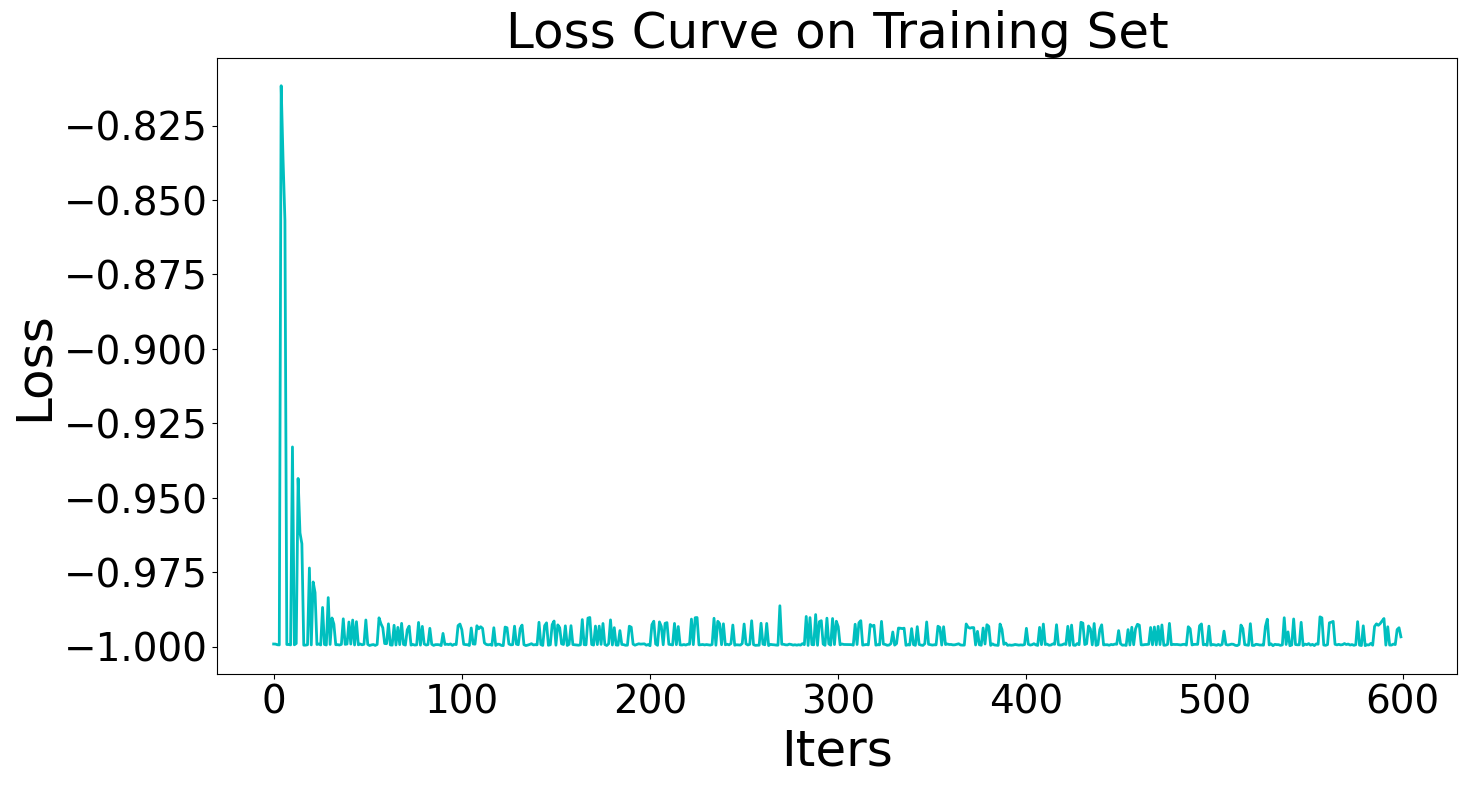

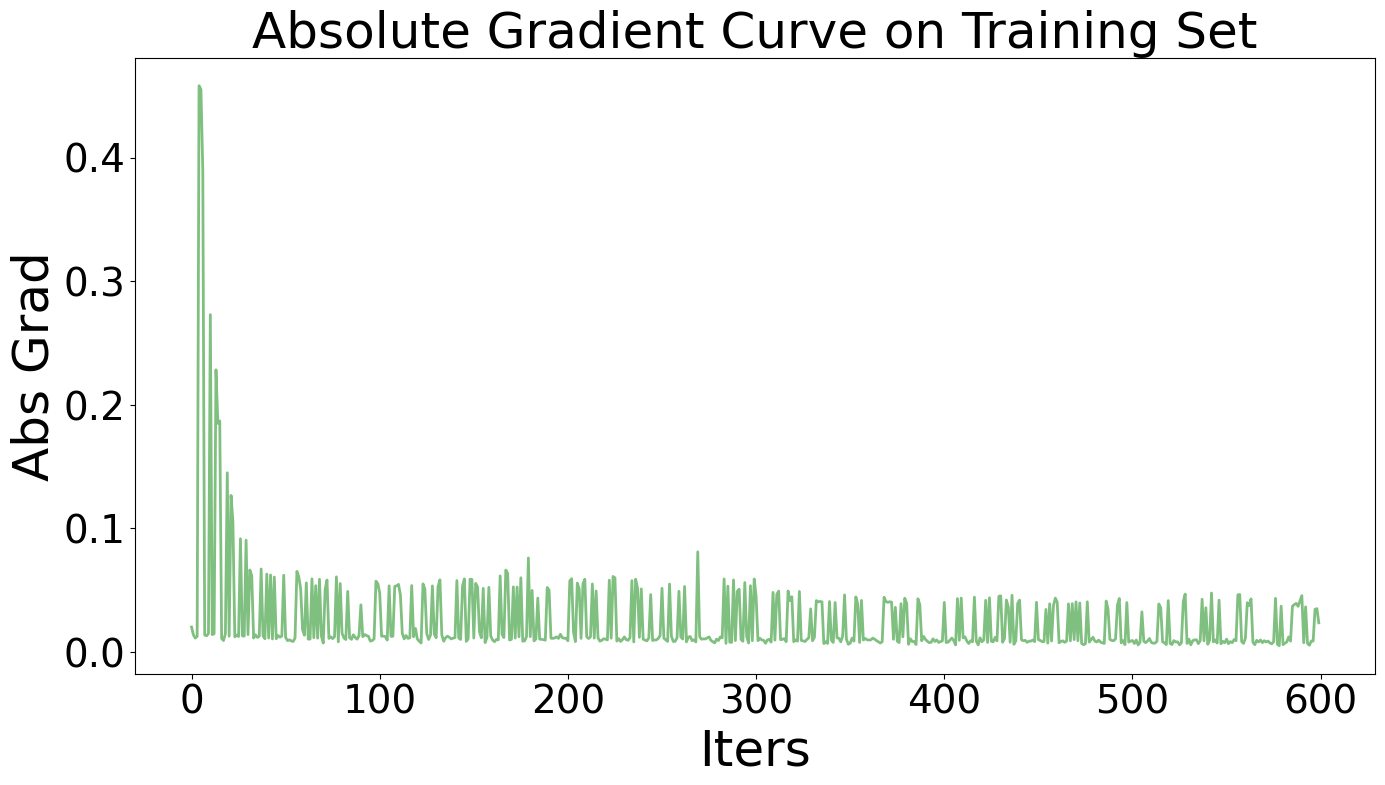


Evaluation:


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:39<00:00,  9.92s/it]

Test Regret: 9.9934%
Test Elapsed Time: 99.19 Sec


In [21]:
lr = 5e-2
pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, loader_train, loader_test)